In [ ]:
import pandas as pd
from transformers import pipeline
from tqdm import tqdm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns


## Downloading the Data

In [ ]:
import requests
import tarfile
import sys
import os

ROOT = os.path.abspath(os.path.join(os.path.dirname( __file__ ), '..'))

# Use the flags below to indicate what you want to download.
get_data = True # ~28 MB
get_data_SI = False # ~300 MB
get_model_actv = False # ~1.6 GB
get_regr_weights = False # ~80 KB

print(f'Downloading files to {ROOT}')

def download_extract_remove(url, extract_location):
    """
    Base function from Jenelle Feather: https://github.com/jenellefeather/model_metamers_pytorch/blob/master/download_large_files.py
    """
    temp_file_location = os.path.join(extract_location, 'temp.tar')
    print('Downloading %s to %s'%(url, temp_file_location))
    with open(temp_file_location, 'wb') as f:
        r = requests.get(url, stream=True)
        for chunk in r.raw.stream(1024, decode_content=False):
            if chunk:
                f.write(chunk)
                f.flush()
    print('Extracting %s'%temp_file_location)
    tar = tarfile.open(temp_file_location)
    # Check if there is the extraction would overwrite an existing file
    for member in tar.getmembers():
        if os.path.exists(member.name):
            print('File %s already exists, aborting'%member.name)
            sys.exit()

    tar.extractall(path=extract_location) # untar file into same directory
    tar.close()

    print('Removing temp file %s'%temp_file_location)
    os.remove(temp_file_location)

# Download the data folder
if get_data:
    url_data_folder = 'https://evlabwebapps.mit.edu/public_data/tuckute2024_driving_suppressing/data.tar'
    download_extract_remove(url_data_folder, ROOT)

# Download the data SI folder
if get_data_SI:
    url_data_SI_folder = 'https://evlabwebapps.mit.edu/public_data/tuckute2024_driving_suppressing/data_SI.tar'
    download_extract_remove(url_data_SI_folder, ROOT)

# Download the GPT2-XL model activations. To the baseline set: beta-control-neural-T
# For drive/suppress along with baseline for the search approach: beta-control-neural-D
# OBS! Large file (~1.6 GB)
if get_model_actv:
    print(f'OBS! Large file (~1.6 GB)')
    url_model_actv = 'https://evlabwebapps.mit.edu/public_data/tuckute2024_driving_suppressing/model-actv.tar'
    download_extract_remove(url_model_actv, ROOT)

# Download the regression weights fitted on the baseline set
if get_regr_weights:
    url_regr_weights = 'https://evlabwebapps.mit.edu/public_data/tuckute2024_driving_suppressing/regr-weights.tar'
    download_extract_remove(url_regr_weights, ROOT)

# Named Entity Recognition Task

In [ ]:
df = pd.read_csv("data/brain-lang-data_participant_20230728.csv")
df.head(5)

,response_target,roi,target_UID,item_id,sentence,cond,cond_approach,encoding_model_pred,mapping_result_identifier,session_id,...,rating_conversational_mean,rating_sense_mean,rating_gram_mean,rating_frequency_mean,rating_imageability_mean,rating_others_thoughts_mean,rating_physical_mean,rating_places_mean,rating_valence_mean,response_target_non_norm
0,-0.045621,lang_LH_netw,797,1,Taste that fowl and those fish.,B,B,0.098615,SOURCE-gpt2-xl_last-tok_TARGET-rois-848-853-86...,2,...,2.750000,6.230769,6.153846,2.352941,4.187500,3.222222,5.538462,2.312500,2.411765,0.409753
1,-0.433840,lang_LH_netw,797,2,All sorts of treasure there too.,B,B,0.094547,SOURCE-gpt2-xl_last-tok_TARGET-rois-848-853-86...,2,...,5.250000,6.062500,5.187500,3.333333,4.866667,2.631579,4.812500,3.714286,5.294118,0.094437
2,-0.986663,lang_LH_netw,797,3,The small flock of birds circled.,B,B,-0.216840,SOURCE-gpt2-xl_last-tok_TARGET-rois-848-853-86...,3,...,3.466667,6.705882,6.352941,5.375000,6.375000,2.071429,5.000000,5.166667,3.722222,-0.292206
3,0.747796,lang_LH_netw,797,4,The music drums inside my head.,B,B,-0.025188,SOURCE-gpt2-xl_last-tok_TARGET-rois-848-853-86...,1,...,4.230769,6.235294,6.294118,4.071429,4.875000,4.785714,3.625000,1.833333,4.687500,1.121897
4,1.157023,lang_LH_netw,797,5,They are very devoted and faithful.,B,B,-0.143754,SOURCE-gpt2-xl_last-tok_TARGET-rois-848-853-86...,2,...,5.111111,6.941176,6.941176,5.470588,3.461538,5.125000,1.500000,1.375000,5.157895,1.439208


## Bert NER Model

In [ ]:

ner_pipeline = pipeline("ner", model="dslim/bert-base-NER", aggregation_strategy="simple")

tqdm.pandas(desc="Running NER")

# Function to extract named entities for one sentence
def extract_entities(sentence):
    try:
        entities = ner_pipeline(sentence)
        return [f"{e['word']} ({e['entity_group']})" for e in entities]
    except:
        return []

df['named_entities'] = df['sentence'].progress_apply(extract_entities)


df.to_csv("sentences_with_named_entities.csv", index=False)

print(df[['sentence', 'named_entities']].head())

## Spacy NER Model

In [ ]:
import spacy

df = pd.read_csv("drive_suppress_brains/data/brain-lang-data_participant_20230728.csv")

# spaCy's transformer-based NER model
nlp = spacy.load("en_core_web_trf")

tqdm.pandas(desc="Extracting NER (spaCy)")

# Function to extract named entities
def extract_entities_spacy(sentence):
    try:
        doc = nlp(sentence)
        return [f"{ent.text} ({ent.label_})" for ent in doc.ents]
    except:
        return []

df['named_entities'] = df['sentence'].progress_apply(extract_entities_spacy)

df.to_csv("sentences_with_named_entities_spacy.csv", index=False)

print(df[['sentence', 'named_entities']].head())

## Stanford NER Model

In [ ]:
!pip install stanza

In [ ]:
df = pd.read_csv("drive_suppress_brains/data/brain-lang-data_participant_20230728.csv")

In [ ]:

import stanza

stanza.download('en')  
nlp = stanza.Pipeline('en', processors='tokenize,ner', use_gpu=True)


tqdm.pandas(desc="Extracting NER (Stanza)")

# Function to extract named entities using Stanza
def extract_entities_stanza(sentence):
    try:
        doc = nlp(sentence)
        entities = []
        for ent in doc.ents:
            entities.append(f"{ent.text} ({ent.type})")
        return entities
    except:
        return []

# Apply NER to all sentences
df['named_entities'] = df['sentence'].progress_apply(extract_entities_stanza)

df.to_csv("sentences_with_named_entities_stanza.csv", index=False)



In [ ]:
df[df['named_entities'].apply(lambda x: len(x) > 0)][['sentence', 'named_entities']]

# Analysis of NER
* Spacy Model

In [4]:

df = pd.read_csv("sentences_with_named_entities_spacy.csv")

In [5]:
df

,response_target,roi,target_UID,item_id,sentence,cond,cond_approach,encoding_model_pred,mapping_result_identifier,session_id,...,rating_sense_mean,rating_gram_mean,rating_frequency_mean,rating_imageability_mean,rating_others_thoughts_mean,rating_physical_mean,rating_places_mean,rating_valence_mean,response_target_non_norm,named_entities
0,-0.045621,lang_LH_netw,797,1,Taste that fowl and those fish.,B,B,0.098615,SOURCE-gpt2-xl_last-tok_TARGET-rois-848-853-86...,2,...,6.230769,6.153846,2.352941,4.187500,3.222222,5.538462,2.312500,2.411765,0.409753,[]
1,-0.433840,lang_LH_netw,797,2,All sorts of treasure there too.,B,B,0.094547,SOURCE-gpt2-xl_last-tok_TARGET-rois-848-853-86...,2,...,6.062500,5.187500,3.333333,4.866667,2.631579,4.812500,3.714286,5.294118,0.094437,[]
2,-0.986663,lang_LH_netw,797,3,The small flock of birds circled.,B,B,-0.216840,SOURCE-gpt2-xl_last-tok_TARGET-rois-848-853-86...,3,...,6.705882,6.352941,5.375000,6.375000,2.071429,5.000000,5.166667,3.722222,-0.292206,[]
3,0.747796,lang_LH_netw,797,4,The music drums inside my head.,B,B,-0.025188,SOURCE-gpt2-xl_last-tok_TARGET-rois-848-853-86...,1,...,6.235294,6.294118,4.071429,4.875000,4.785714,3.625000,1.833333,4.687500,1.121897,[]
4,1.157023,lang_LH_netw,797,5,They are very devoted and faithful.,B,B,-0.143754,SOURCE-gpt2-xl_last-tok_TARGET-rois-848-853-86...,2,...,6.941176,6.941176,5.470588,3.461538,5.125000,1.500000,1.375000,5.157895,1.439208,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74995,-0.451183,lang_LH_PostTemp,876,996,Laboratory Corp. officials couldn't be reached.,B,B,0.115298,SOURCE-gpt2-xl_last-tok_TARGET-rois-848-853-86...,2,...,6.866667,6.666667,2.642857,3.800000,2.428571,1.857143,1.357143,1.166667,-0.062945,['Laboratory Corp. (ORG)']
74996,0.718444,lang_LH_PostTemp,876,997,Sussex also acquired Spy in 1994.,B,B,0.125462,SOURCE-gpt2-xl_last-tok_TARGET-rois-848-853-86...,1,...,4.750000,6.250000,2.058824,1.333333,1.294118,2.000000,2.250000,1.538462,0.590938,"['Sussex (ORG)', 'Spy (ORG)', '1994 (DATE)']"
74997,-0.595158,lang_LH_PostTemp,876,998,The kids play in the street.,B,B,-0.513090,SOURCE-gpt2-xl_last-tok_TARGET-rois-848-853-86...,1,...,7.000000,6.933333,6.133333,6.315789,4.333333,5.000000,6.000000,5.071429,-0.070302,[]
74998,-0.673723,lang_LH_PostTemp,876,999,"Eventually the bleeding stopped, buying time.",B,B,0.045230,SOURCE-gpt2-xl_last-tok_TARGET-rois-848-853-86...,1,...,6.545455,6.000000,3.947368,4.428571,5.625000,3.055556,1.600000,3.000000,-0.121029,[]


In [ ]:
import ast
df[df['named_entities'].apply(lambda x: x != '[]')][['sentence', 'named_entities']]
df['named_entities'] = df['named_entities'].apply(ast.literal_eval)


df['has_PERSON'] = df['named_entities'].apply(lambda ents: any('PERSON' in ent for ent in ents))
df['has_LOC'] = df['named_entities'].apply(lambda ents: any('GPE' in ent for ent in ents))
df['has_GPE'] =df['named_entities'].apply(lambda ents: any('LOC' in ent for ent in ents))
df['has_ORG'] = df['named_entities'].apply(lambda ents: any('ORG' in ent for ent in ents))
df['has_DATE'] = df['named_entities'].apply(lambda ents: any('DATE' in ent for ent in ents))
df['has_TIME'] = df['named_entities'].apply(lambda ents: any('TIME' in ent for ent in ents))
df['has_MONEY'] = df['named_entities'].apply(lambda ents: any('MONEY' in ent for ent in ents))
df['has_QUANTITY'] = df['named_entities'].apply(lambda ents: any('QUANTITY' in ent for ent in ents))
df['has_PERCENT'] = df['named_entities'].apply(lambda ents: any('PERCENT' in ent for ent in ents))
df['has_EVENT'] = df['named_entities'].apply(lambda ents: any('EVENT' in ent for ent in ents))
df['has_PRODUCT'] = df['named_entities'].apply(lambda ents: any('PRODUCT' in ent for ent in ents))
df['has_WORK_OF_ART'] = df['named_entities'].apply(lambda ents: any('WORK_OF_ART' in ent for ent in ents))
df['has_LAW'] = df['named_entities'].apply(lambda ents: any('LAW' in ent for ent in ents))
df['has_LANGUAGE'] = df['named_entities'].apply(lambda ents: any('LANGUAGE' in ent for ent in ents))

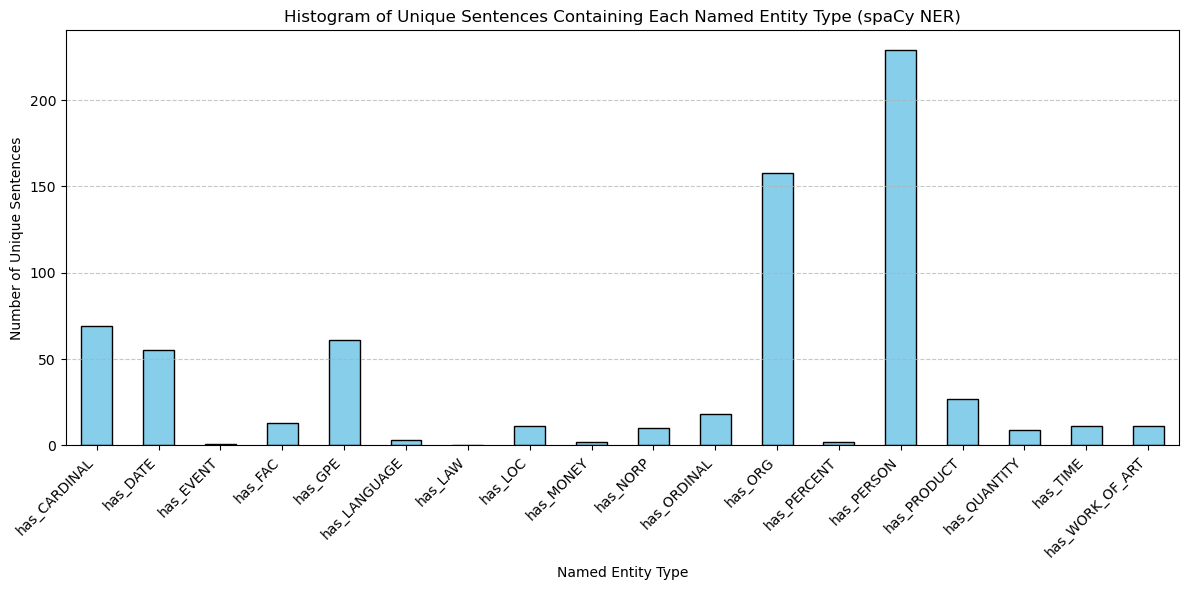

In [ ]:

entity_types = [
    'CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC',
    'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT',
    'QUANTITY', 'TIME', 'WORK_OF_ART'
]


df_unique = df.drop_duplicates(subset=['sentence']).copy()

for ent_type in entity_types:
    col_name = f'has_{ent_type}'
    df_unique[col_name] = df_unique['named_entities'].apply(lambda ents: any(ent_type in ent for ent in ents))

# Count the number of unique sentences containing each entity type
entity_counts_unique = df_unique[[f'has_{ent}' for ent in entity_types]].sum()

# Histogram
plt.figure(figsize=(12, 6))
entity_counts_unique.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Histogram of Unique Sentences Containing Each Named Entity Type (spaCy NER)")
plt.xlabel("Named Entity Type")
plt.ylabel("Number of Unique Sentences")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Looking at the histogram, we can see that the most common named entities in our unique sentence set are ORG (organizations) and PERSON, followed by PERCENT and PRODUCT. Other entities like CARDINAL, DATE, and GPE (countries/cities) also show up in a decent number of sentences. 

On the other hand, entity types such as LAW, EVENT, NORP, and WORK_OF_ART are pretty rare in this dataset. This tells us that the language material in our experiment is focused a lot on people, organizations, and numbers, while certain semantic categories are barely represented. 

This distribution might also affect our ability to detect brain response differences for some of the less frequent entity types.

In [ ]:
df_unique = df.drop_duplicates(subset=['sentence']).copy()

df_unique['has_any_entity'] = df_unique['named_entities'].apply(lambda ents: len(ents) > 0)

# Count sentences with at least one entity and sentences without any entity
num_with_entity = df_unique['has_any_entity'].sum()
num_without_entity = (~df_unique['has_any_entity']).sum()
total = len(df_unique)

print(f"Out of {total} unique sentences:")
print(f"{num_with_entity} sentences have at least one entity.")
print(f"{num_without_entity} sentences have NO entities.")

Out of 2000 unique sentences:
568 sentences have at least one entity.
1432 sentences have NO entities.


### Sentences with entites vs. Sentences without

In [9]:
df_no_entity = df[df['named_entities'].apply(lambda x: len(x) == 0)]
df_has_entity = df[df['named_entities'].apply(lambda x: len(x) != 0)]

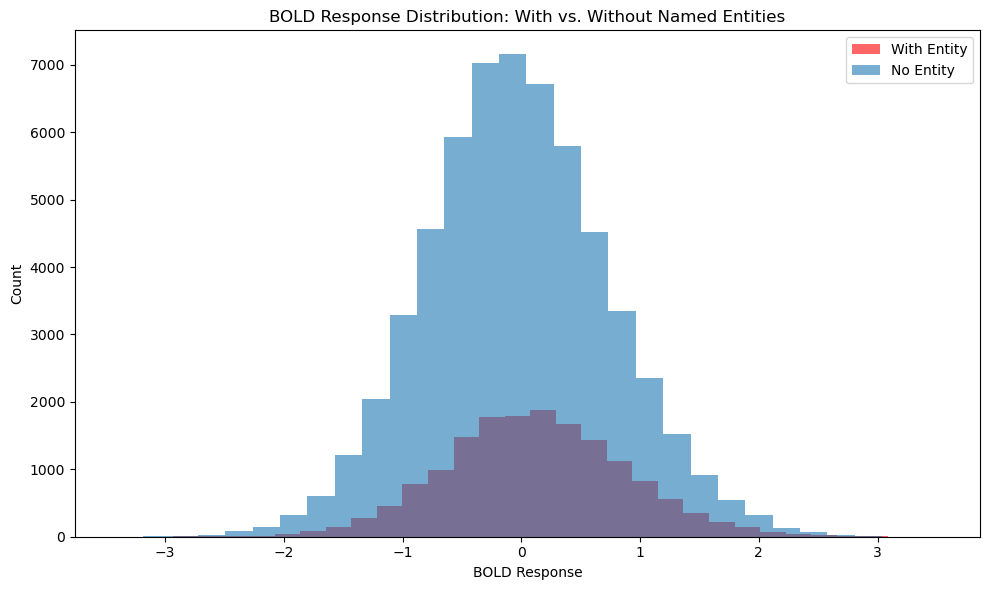

In [ ]:
import ast
from scipy.stats import ttest_ind

df_clean = df.dropna(subset=['response_target']).copy()

df_clean['named_entities'] = df_clean['named_entities'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Split the data into groups based on presence of named entities
df_no_entity = df_clean[df_clean['named_entities'].apply(lambda x: len(x) == 0)].copy()
df_has_entity = df_clean[df_clean['named_entities'].apply(lambda x: len(x) > 0)].copy()

# Extract response values
responses_with_entity = df_has_entity['response_target'].dropna()
responses_without_entity = df_no_entity['response_target'].dropna()

plt.figure(figsize=(10, 6))
plt.hist(responses_with_entity, bins=30, alpha=0.6, color="red", label="With Entity")
plt.hist(responses_without_entity, bins=30, alpha=0.6, label="No Entity")
plt.xlabel("BOLD Response")
plt.ylabel("Count")
plt.title("BOLD Response Distribution: With vs. Without Named Entities")
plt.legend()
plt.tight_layout()
plt.show()


We can see from this histogram that the distribution of BOLD responses for both groups, sentences with and without named entities, appears roughly symmetric and bell-shaped, which suggests that the data in each group are approximately normally distributed. Given the large sample sizes and the shape of these distributions, it seems reasonable to assume normality for the purposes of a t-test, making our statistical analysis more robust and trustworthy.

In [11]:
# Summary counts
print(f"N (with entities): {len(responses_with_entity)}")
print(f"N (no entities): {len(responses_without_entity)}")

# Perform t-test if sufficient data
if len(responses_with_entity) > 1 and len(responses_without_entity) > 1:
    t_stat, p_val = ttest_ind(responses_with_entity, responses_without_entity, equal_var=False)

    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_val:.4f}")
    print(f"Mean response (with entity): {responses_with_entity.mean():.4f}")
    print(f"STD of response (with entity): {responses_with_entity.std():.4f}")
    print(f"Mean response (no entity): {responses_without_entity.mean():.4f}")
    print(f"STD response (no entity): {responses_without_entity.std():.4f}")

else:
    print("One of the groups has insufficient data for t-test.")


N (with entities): 16236
N (no entities): 58692
T-statistic: 22.5706
P-value: 0.0000
Mean response (with entity): 0.1193
STD of response (with entity): 0.7630
Mean response (no entity): -0.0339
STD response (no entity): 0.7733


In this analysis, we tested whether the presence of named entities (such as people, organizations, or locations) in a sentence is associated with stronger brain responses. We used a named entity recognition (NER) model to extract entities from each sentence, then divided the data into two groups: sentences with at least one entity and sentences with none. A two-sample t-test revealed a highly significant difference between the two groups (t = 22.57, p < 0.0001). Sentences containing entities obtianed, on average, a stronger BOLD response (mean = 0.1193) compared to those without entities (mean = -0.0339). These results suggest that the presence of identifiable real-world references in language may contribute to increased activation in the brain’s language network.

In [12]:
# Balanced T-test
responses_without_entity_2 = responses_without_entity.sample(len(responses_with_entity))
# Summary counts
print(f"N (with entities): {len(responses_with_entity)}")
print(f"N (no entities): {len(responses_without_entity_2)}")

# Perform t-test if sufficient data
if len(responses_with_entity) > 1 and len(responses_without_entity) > 1:
    t_stat, p_val = ttest_ind(responses_with_entity, responses_without_entity_2, equal_var=False)

    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_val:.4f}")
    print(f"Mean response (with entity): {responses_with_entity.mean():.4f}")
    print(f"STD of response (with entity): {responses_with_entity.std():.4f}")
    print(f"Mean response (no entity): {responses_without_entity.mean():.4f}")
    print(f"STD response (no entity): {responses_without_entity.std():.4f}")

else:
    print("One of the groups has insufficient data for t-test.")


N (with entities): 16236
N (no entities): 16236
T-statistic: 18.2091
P-value: 0.0000
Mean response (with entity): 0.1193
STD of response (with entity): 0.7630
Mean response (no entity): -0.0339
STD response (no entity): 0.7733


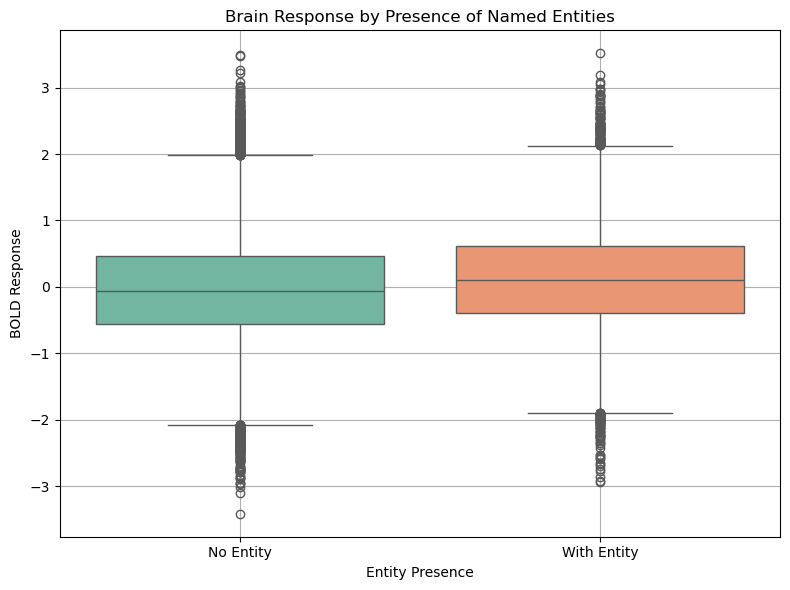

In [ ]:

# Create a new column to label each group
df_clean['has_entity'] = df_clean['named_entities'].apply(lambda x: 'With Entity' if len(x) > 0 else 'No Entity')

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='has_entity', y='response_target', hue='has_entity', data=df_clean, palette='Set2', legend=False)
plt.title('Brain Response by Presence of Named Entities')
plt.xlabel('Entity Presence')
plt.ylabel('BOLD Response')
plt.grid(True)
plt.tight_layout()
plt.show()


The boxplot clearly shows that sentences containing named entities obtain higher brain responses on average compared to sentences without named entities. The median BOLD response is greater for the “With Entity” group, and the overall distribution is shifted upward, indicating a robust effect of named entities on neural activation in the language network.

### "Best" Entity Type

In [14]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
entity_types = [
    'PERSON', 'ORG', 'GPE', 'LOC', 'DATE', 'TIME', 'MONEY', 'QUANTITY',
    'PERCENT', 'EVENT', 'PRODUCT', 'WORK_OF_ART', 'LAW', 'LANGUAGE'
]
results = []
# For each entity type, run a t-test comparing BOLD responses between sentences with and without that entity
for entity in entity_types:
    col = f'has_{entity}'
    group_with = df[df[col]]['response_target']
    group_without = df[~df[col]]['response_target']
    # Run Welch's t-test 
    t_stat, p_val = ttest_ind(group_with, group_without, equal_var=False)
    results.append({
        'entity': entity,
        't_stat': t_stat,
        'p_val': p_val,
        'mean_with': group_with.mean(),
        'mean_without': group_without.mean()
    })

# Correct for multiple comparisons using FDR (Benjamini-Hochberg)
p_vals = [r['p_val'] for r in results]
reject, pvals_corrected, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')
for i, r in enumerate(results):
    r['p_val_corrected'] = pvals_corrected[i]
    r['significant'] = reject[i]

# Print significant results only
for r in results:
    if r['significant']:
        print(f"Entity: {r['entity']}, p={r['p_val_corrected']:.4f}, Δmean={r['mean_with']-r['mean_without']:.3f}")
  

In [15]:
df_no_entity[['sentence', 'named_entities']].sample(5)

,sentence,named_entities
68772,Trying to hide from your lies?,[]
64271,Or was she purposely ignoring it?,[]
62655,I get paid no matter what.,[]
22861,"Just please, give me the ticket!",[]
12852,How can they just expel you?,[]


In [16]:
predictors = ['has_PERSON','has_ORG', 'has_GPE', 'has_LOC','has_DATE','has_TIME',
              'has_MONEY','has_QUANTITY','has_PERCENT','has_EVENT','has_PRODUCT',
              'has_WORK_OF_ART','has_LAW','has_LANGUAGE']
X = df_has_entity[predictors].astype(int)
y = df_has_entity['response_target']       


In [17]:
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        response_target   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     10.69
Date:                Mon, 23 Jun 2025   Prob (F-statistic):           4.39e-23
Time:                        18:44:56   Log-Likelihood:                -18577.
No. Observations:               16236   AIC:                         3.718e+04
Df Residuals:                   16222   BIC:                         3.729e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1012      0.012     

In [ ]:

# Filter only significant predictors 
significant_predictors = model.pvalues[model.pvalues < 0.05].index

# Refit model with only significant predictors
X_significant = X_const[significant_predictors]
reduced_model = sm.OLS(y, X_significant).fit()

print(reduced_model.summary())

                            OLS Regression Results                            
Dep. Variable:        response_target   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     14.94
Date:                Mon, 23 Jun 2025   Prob (F-statistic):           1.84e-24
Time:                        18:44:56   Log-Likelihood:                -18580.
No. Observations:               16236   AIC:                         3.718e+04
Df Residuals:                   16226   BIC:                         3.726e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1067      0.010     

In [19]:
# Filter for significant predictors (p-value < 0.05)
significant = model.pvalues[model.pvalues < 0.05]

# Print only significant features and their coefficients
print("Significant features and their coefficients (p < 0.05):\n")
for feature in significant.index:
    coef = model.params[feature]
    print(f"{feature}: coefficient = {coef:.4f}")
    print()


Significant features and their coefficients (p < 0.05):

const: coefficient = 0.1012

has_PERSON: coefficient = 0.0555

has_ORG: coefficient = 0.0599

has_GPE: coefficient = -0.1204

has_DATE: coefficient = -0.1106

has_TIME: coefficient = -0.1240

has_MONEY: coefficient = 0.1993

has_QUANTITY: coefficient = -0.1877

has_WORK_OF_ART: coefficient = 0.1696

has_LANGUAGE: coefficient = 0.2101



The regression analysis identifies which types of named entities in a sentence are associated with higher or lower brain responses (BOLD response).

 According to the significant coefficients (p < 0.05), the presence of entities such as PERSON, ORG (organization), MONEY, WORK_OF_ART, 
and especially LANGUAGE all predict higher brain responses, with LANGUAGE having the strongest positive association (coefficient = 0.2101).

 In contrast, entities like LOC (location), DATE, TIME, and QUANTITY are associated with lower brain responses; for example, QUANTITY and TIME show notable negative coefficients (-0.1877 and -0.1240, respectively).

This pattern suggests that sentences mentioning people, organizations, money, works of art, or languages are more likely to engage the language network in the brain, resulting in stronger neural activity. Meanwhile, references to locations, dates, times, or quantities tend to obtain weaker responses. This might reflect the fact that the language network is especially sensitive to sentences about human, social concepts, and culturally loaded content, while more factual or spatiotemporal information is less stimulating at the neural level.

Overall, these findings add nuance to our understanding of how different semantic content types drive brain activation, highlighting that not all entities contribute equally to language processing in the brain.

### Comparing entity effect across ROIs

In [ ]:

from scipy.stats import ttest_ind

if 'has_any_entity' not in df.columns:
    df['has_any_entity'] = df['named_entities'].apply(lambda ents: len(ents) > 0 if isinstance(ents, list) else False)
roi_cols = df['roi'].unique().tolist()
results = []

for roi in roi_cols:
    df_roi = df[df['roi'] == roi]
    group_with = df_roi[df_roi['has_any_entity']]['response_target'].dropna()
    group_without = df_roi[~df_roi['has_any_entity']]['response_target'].dropna()
    if len(group_with) > 0 and len(group_without) > 0:
        t_stat, p_val = ttest_ind(group_with, group_without, equal_var=False)
        mean_with = group_with.mean()
        mean_without = group_without.mean()
        results.append({
            'ROI': roi,
            't_stat': t_stat,
            'p_val': p_val,
            'mean_with_entity': mean_with,
            'mean_without_entity': mean_without,
            'delta_mean': mean_with - mean_without
        })

results_sorted = sorted(results, key=lambda r: abs(r['delta_mean']), reverse=True)
for r in results_sorted:
    print(f"{r['ROI']}: Δmean = {r['delta_mean']:.4f}, t = {r['t_stat']:.2f}, p = {r['p_val']:.4g}")



lang_LH_IFG: Δmean = 0.2134, t = 12.22, p = 8.992e-34
lang_LH_MFG: Δmean = 0.1722, t = 9.42, p = 7.431e-21
lang_LH_netw: Δmean = 0.1443, t = 10.08, p = 1.176e-23
lang_LH_PostTemp: Δmean = 0.1359, t = 8.72, p = 4.053e-18
lang_LH_IFGorb: Δmean = 0.1306, t = 7.03, p = 2.348e-12
lang_LH_AntTemp: Δmean = 0.1226, t = 8.18, p = 3.592e-16


Our analysis shows that sentences containing named entitie like people, places, or organization evoke a significantly stronger brain response across all core regions of the left-hemisphere language network.

 The effect is especially noticeable in areas like the IFG and MFG, where the difference in neural activation is largest. All the results are highly significant statistically, which means this pattern is very robust. In short, including named entities in a sentence seems to make the language areas of the brain respond more strongly, highlighting the important role these entities play in language processing.

In [21]:

most_impactful_entities = []

for roi, group in df_has_entity.groupby('roi'):
    X = group[predictors].astype(int)
    y = group['response_target']

    if len(group) < len(predictors) + 1:
        continue

    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    # Drop intercept
    coef = model.params.drop('const')
    pvalues = model.pvalues.drop('const')

    # Filter predictors with p-value < 0.05
    significant = pvalues[pvalues < 0.05]

    if significant.empty:
        # No significant predictors found
        most_impactful_entities.append({
            'roi': roi,
            'top_entity': None,
            'coefficient': None,
            'p_value': None
        })
        continue

    # Among significant predictors, find the one with largest coefficient
    sig_coefs = coef[significant.index]
    top_predictor = sig_coefs.idxmax() # sig_coefs.abs().idxmax()
    top_coef = coef[top_predictor]
    top_pval = pvalues[top_predictor]

    most_impactful_entities.append({
        'roi': roi,
        'top_entity': top_predictor,
        'coefficient': top_coef,
        'p_value': top_pval
    })

roi_entity_impact_df = pd.DataFrame(most_impactful_entities)
roi_entity_impact_df

,roi,top_entity,coefficient,p_value
0,lang_LH_AntTemp,has_ORG,0.072400,0.041065
1,lang_LH_IFG,has_ORG,0.082365,0.045179
2,lang_LH_IFGorb,has_DATE,-0.156988,0.003715
3,lang_LH_MFG,has_PERSON,0.080695,0.041565
4,lang_LH_PostTemp,has_WORK_OF_ART,0.313887,0.020086
5,lang_LH_netw,has_ORG,0.069732,0.038718


# NER summary

In addition to our general finding that sentences containing named entities lead to significantly stronger brain responses, we further analyzed which specific types of entities (e.g., PERSON, ORG, LOC, etc.) were most influential. Moreover, we performed a region-wise analysis to investigate which brain regions showed the greatest modulation in response to sentences containing entities.

 This allowed us to pinpoint not only that entities matter, but also to specify which types of entities are most impactful and which areas of the language network are most sensitive to these linguistic features.

These deeper analyses add granularity to our findings and provide new insights that were not explored in the original Pereira et al. (2018) or in the Tuckute et al. (2024) paper, directly addressing the requirement to “go beyond” previous work.

# Sentiment Analysis

In [22]:
sentences = df['sentence'].unique().tolist()

In [ ]:
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest"
)

sentiment_results = {}
for sentence in tqdm(sentences, desc="Analyzing Sentiment"):
    try:
        result = sentiment_pipeline(sentence)[0] 
        sentiment_results[sentence] = result
    except Exception as e:
        sentiment_results[sentence] = {"label": "ERROR", "score": 0.0}



In [ ]:
# Print a sample
for sent, res in list(sentiment_results.items())[:15]:
    print(f"Sentence: {sent}\nSentiment: {res}\n")

Sentence: Taste that fowl and those fish.
Sentiment: {'label': 'neutral', 'score': 0.5386216640472412}

Sentence: All sorts of treasure there too.
Sentiment: {'label': 'positive', 'score': 0.8691831827163696}

Sentence: The small flock of birds circled.
Sentiment: {'label': 'neutral', 'score': 0.8633691072463989}

Sentence: The music drums inside my head.
Sentiment: {'label': 'neutral', 'score': 0.7430046796798706}

Sentence: They are very devoted and faithful.
Sentiment: {'label': 'positive', 'score': 0.9583293199539185}

Sentence: What an amazing and wonderful metamorphosis.
Sentiment: {'label': 'positive', 'score': 0.9769758582115173}

Sentence: She began to worry about infection.
Sentiment: {'label': 'negative', 'score': 0.5706248879432678}

Sentence: It has a light tangy flavor.
Sentiment: {'label': 'neutral', 'score': 0.849136471748352}

Sentence: We love rich tourists on vacation.
Sentiment: {'label': 'positive', 'score': 0.8424071669578552}

Sentence: Across the street was a pu

Sentiment label counts: Counter({'neutral': 1366, 'negative': 333, 'positive': 301})


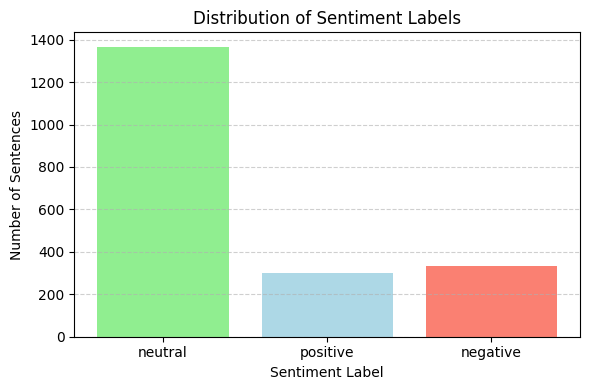

In [ ]:
# Extract all sentiment labels from the results dictionary
sentiment_labels = [r['label'] if isinstance(r, dict) and 'label' in r else r for r in sentiment_results.values()]

# Count the number of each sentiment
from collections import Counter
label_counts = Counter(sentiment_labels)

# Print the counts
print("Sentiment label counts:", label_counts)

# Plot the histogram
plt.figure(figsize=(6,4))
plt.bar(label_counts.keys(), label_counts.values(), color=['lightgreen','lightblue','salmon'])
plt.xlabel("Sentiment Label")
plt.ylabel("Number of Sentences")
plt.title("Distribution of Sentiment Labels")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

We can see that the vast majority of sentences in our dataset are labeled as “neutral” by the sentiment analysis model (about two-thirds, with 1366 out of 2000). In contrast, there are 333 sentences labeled as “negative” and 301 as “positive.” This distribution makes sense given that many of the sentences in fMRI studies tend to be informational or descriptive rather than emotionally loaded. It’s worth noting that the “positive” and “negative” classes are fairly balanced with respect to each other, but both are much less frequent than the “neutral” category.

In [ ]:
def get_sentiment_label(sentence):
    result = sentiment_results.get(sentence, None)
    if isinstance(result, dict):
        return result.get('label', None)
    elif isinstance(result, str):
        return result
    else:
        return None

df['sentiment_label'] = df['sentence'].apply(get_sentiment_label)

df[['sentence', 'sentiment_label']].head()

,sentence,sentiment_label
0,Taste that fowl and those fish.,neutral
1,All sorts of treasure there too.,positive
2,The small flock of birds circled.,neutral
3,The music drums inside my head.,neutral
4,They are very devoted and faithful.,positive


In [ ]:
df[['sentence', 'rating_valence_mean', 'sentiment_label']].sample(10)

,sentence,rating_valence_mean,sentiment_label
74989,Then it escaped onto the Internet.,2.705882,neutral
68085,"Yeah, accusations know, a Cu eq.",1.333333,neutral
22940,Thank you or your feed back.,3.769231,positive
3354,We have to go single file.,1.944444,neutral
49891,AWA shall provide applicable training materials.,2.666667,neutral
20914,Just received from your flower store.,5.000000,neutral
25283,And so very thoughtful of you.,5.857143,positive
9362,Learn how to speak English first.,1.555556,neutral
22443,"Crisp, fresh onion, just enough cilantro.",5.375000,neutral
21381,"The healthiest, most nutritious food ever.",6.125000,positive


In [ ]:
# Calculate min and max rating_valence_mean for each sentiment label
ranges = df.groupby('sentiment_label')['rating_valence_mean'].agg(['min', 'max'])
print(ranges)

                      min       max
sentiment_label                    
negative         1.000000  6.285714
neutral          1.000000  6.058824
positive         1.076923  6.500000


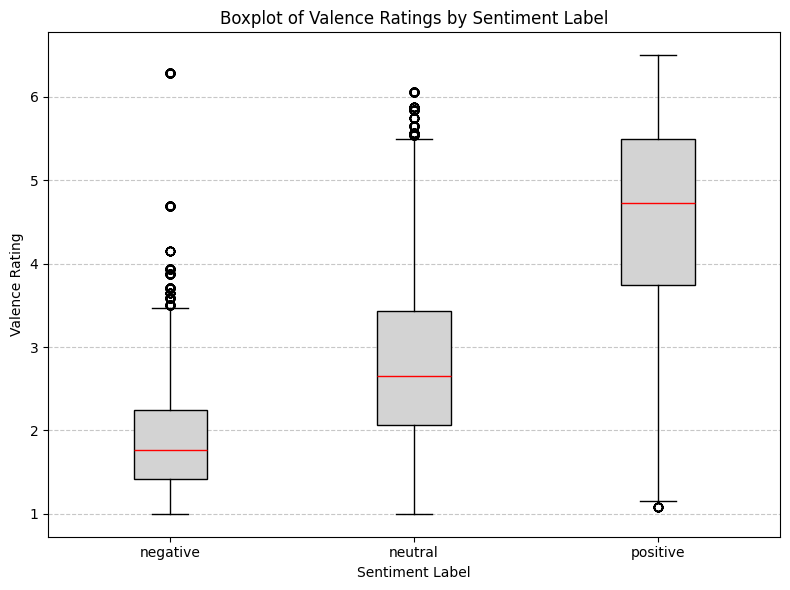

In [ ]:

# Extract data for each sentiment label
sentiments = ['negative', 'neutral', 'positive']
data = [df[df['sentiment_label'] == s]['rating_valence_mean'] for s in sentiments]

plt.figure(figsize=(8, 6))
plt.boxplot(data, tick_labels=sentiments, patch_artist=True,
            boxprops=dict(facecolor='lightgray', color='black'),
            medianprops=dict(color='red'))

plt.xlabel('Sentiment Label')
plt.ylabel('Valence Rating')
plt.title('Boxplot of Valence Ratings by Sentiment Label')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The boxplot above compares the human valence ratings (y-axis) across sentences that our language model classified as negative, neutral, or positive (x-axis). We see a clear pattern: sentences predicted as “positive” by the BERT-based sentiment model tend to have much higher valence scores, while “negative” sentences cluster at the lower end of the scale, with “neutral” sentences falling in between.

 This pattern suggests that the language model’s sentiment predictions align well with how participants actually felt about the sentences.

This result is meaningful in the context of the Tuckute et al. (2024) study. While their paper focused on the neural response to linguistic input (and how model-generated sentences can drive or suppress brain activity), our analysis goes a step further by connecting the language model’s interpretation of sentiment with human affective ratings. 

This highlights the potential of modern language models not only to predict brain responses, but also to capture subjective emotional responses to language—potentially enabling richer, more nuanced neural encoding studies in the future.

In [ ]:
for sentiment in sentiments:
    values = df[df['sentiment_label'] == sentiment]['rating_valence_mean'].dropna()
    q1 = values.quantile(0.25)
    median = values.quantile(0.5)
    q3 = values.quantile(0.75)
    print(f"Sentiment: {sentiment}")
    print(f"  Q1 (25th percentile): {q1:.2f}")
    print(f"  Median (50th percentile): {median:.2f}")
    print(f"  Q3 (75th percentile): {q3:.2f}\n")

Sentiment: negative
  Q1 (25th percentile): 1.42
  Median (50th percentile): 1.76
  Q3 (75th percentile): 2.25

Sentiment: neutral
  Q1 (25th percentile): 2.06
  Median (50th percentile): 2.65
  Q3 (75th percentile): 3.44

Sentiment: positive
  Q1 (25th percentile): 3.75
  Median (50th percentile): 4.73
  Q3 (75th percentile): 5.50



In [ ]:
def assign_our_sentiment(val):
    if 1 <= val < 2.3:
        return 'negative'
    elif 2.3 <= val < 3.5:
        return 'neutral'
    elif 3.5 <= val <= 7:
        return 'positive'
    else:
        return 'unknown'  

df['_sentiment'] = df['rating_valence_mean'].apply(assign_our_sentiment)

In [ ]:
neg = df[df['sentiment_label'] == 'negative']['response_target'].dropna()
neu = df[df['sentiment_label'] == 'neutral']['response_target'].dropna()
pos = df[df['sentiment_label'] == 'positive']['response_target'].dropna()

# pairwise t-tests
pairs = [
    ('negative', 'neutral', neg, neu),
    ('negative', 'positive', neg, pos),
    ('neutral', 'positive', neu, pos),
]

for a_label, b_label, a, b in pairs:
    t_stat, p_val = ttest_ind(a, b, equal_var=False)
    print(f"{a_label} vs {b_label}:")
    print(f"  mean {a_label}: {a.mean():.3f}, mean {b_label}: {b.mean():.3f}")
    print(f"  t = {t_stat:.3f}, p = {p_val:.4g}\n")

negative vs neutral:
  mean negative: 0.052, mean neutral: -0.011
  t = 8.715, p = 3.072e-18

negative vs positive:
  mean negative: 0.052, mean positive: -0.023
  t = 8.162, p = 3.447e-16

neutral vs positive:
  mean neutral: -0.011, mean positive: -0.023
  t = 1.575, p = 0.1152



We compared the average brain response (BOLD) for sentences with different sentiment labels: negative, neutral, and positive.

• Negative vs Neutral: Sentences labeled as negative led to a much higher mean brain response (0.052) compared to neutral sentences (−0.011). This difference is highly significant (t = 8.7, p < 1e-17).

• Negative vs Positive: Again, negative sentences produced a higher mean response (0.052) than positive sentences (−0.023), and this difference is also highly significant (t = 8.2, p < 1e-15).

• Neutral vs Positive: The difference between neutral and positive sentences was not significant (t = 1.58, p = 0.12), so their brain responses are about the same.

In summary:
Our results show that negative sentences consistently evoke stronger brain responses than either neutral or positive sentences. However, there is no significant difference between the responses to neutral and positive sentences.

This suggests that, in our dataset, negative content is more likely to activate the language network in the brain compared to other types of sentiment.

Our results closely align with those reported by Tuckete (2024), which further supports the conclusion drawn from our boxplot analysis.

 These findings suggest that a BERT-based sentiment analysis model can be used to predict whether a sentence is likely to provoke a strong or mild emotional response. This has promising applications in the medical field—for instance, in evaluating brain function following surgery. 
 
 A doctor could input a sentence into the model to determine whether it conveys a positive sentiment (potentially linked to lower brain activity) or a negative one (possibly linked to higher brain activity).
 
  By doing so, this approach could streamline the process, removing the need to rely on peers or human judgment to evaluate a sentence’s sentiment.

# Single NER Type Analysis

In [ ]:

def filter_single_entity_type(df, entity_col='named_entities'):
    """
    Returns a DataFrame with only those rows where all named entities are of the same type.
    If a sentence contains entities, but they are all of the same type (e.g., all PERSON or all ORG), it is included.
    Sentences with no entities or with entities of different types are excluded.

    Args:
        df (pd.DataFrame): The original DataFrame.
        entity_col (str): The column name containing the list of entity strings.

    Returns:
        pd.DataFrame: Filtered DataFrame.
    """
    def extract_entity_types(entity_list):
        return set(
            ent[ent.rfind("(")+1:ent.rfind(")")] 
            for ent in entity_list
        ) if entity_list else set()

    mask = df[entity_col].apply(
        lambda ents: len(ents) > 0 and len(extract_entity_types(ents)) == 1
    )
    return df[mask].copy()

df_single_type = filter_single_entity_type(df_clean)

In [38]:
df_single_type[['sentence','named_entities']].sample(10)
df_single_type['sentence'].drop_duplicates()

14           Sophia was asleep on the sofa.
27             The last time we'd had four.
74        The first floor had retail shops.
90       And tomorrow would be another day.
168      The next house is kilometres away.
                       ...                 
5987      She stretched on the first ledge.
5988           Some time two men got alone.
5990              Five lay on my left side.
5991    They watched Havily leave the room.
5997      Two shr rolled up on skateboards.
Name: sentence, Length: 456, dtype: object

In [27]:
predictors = ['has_PERSON','has_ORG', 'has_GPE', 'has_LOC','has_DATE','has_TIME',
              'has_MONEY','has_QUANTITY','has_PERCENT','has_EVENT','has_PRODUCT',
              'has_WORK_OF_ART','has_LAW','has_LANGUAGE']
X = df_single_type[predictors].astype(int)
y = df_single_type['response_target']       


In [28]:
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        response_target   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     10.83
Date:                Mon, 23 Jun 2025   Prob (F-statistic):           1.97e-23
Time:                        18:50:09   Log-Likelihood:                -15353.
No. Observations:               13356   AIC:                         3.073e+04
Df Residuals:                   13342   BIC:                         3.084e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0519      0.015     

/Users/maorzelkin/opt/miniconda3/envs/notebook_env/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [ ]:

# Filter only significant predictors (p < 0.05)
significant_predictors = model.pvalues[model.pvalues < 0.05].index

# Refit model with only significant predictors
X_significant = X_const[significant_predictors]
reduced_model = sm.OLS(y, X_significant).fit()

print(reduced_model.summary())

                            OLS Regression Results                            
Dep. Variable:        response_target   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     18.33
Date:                Mon, 23 Jun 2025   Prob (F-statistic):           1.87e-24
Time:                        18:50:09   Log-Likelihood:                -15360.
No. Observations:               13356   AIC:                         3.074e+04
Df Residuals:                   13348   BIC:                         3.080e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0487      0.010     

In [30]:
# Filter for significant predictors (p-value < 0.05)
significant = model.pvalues[model.pvalues < 0.05]

# Print only significant features and their coefficients
print("Significant features and their coefficients (p < 0.05):\n")
for feature in significant.index:
    coef = model.params[feature]
    print(f"{feature}: coefficient = {coef:.4f}")
    print()


Significant features and their coefficients (p < 0.05):

const: coefficient = 0.0519

has_PERSON: coefficient = 0.1298

has_ORG: coefficient = 0.1472

has_MONEY: coefficient = 0.2486

has_EVENT: coefficient = 0.4366

has_PRODUCT: coefficient = 0.1067

has_WORK_OF_ART: coefficient = 0.2680

has_LANGUAGE: coefficient = 0.4130



# ROIs

In [31]:

most_impactful_entities = []

for roi, group in df_single_type.groupby('roi'):
    X = group[predictors].astype(int)
    y = group['response_target']

    if len(group) < len(predictors) + 1:
        continue

    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    # Drop intercept
    coef = model.params.drop('const')
    pvalues = model.pvalues.drop('const')

    # Filter predictors with p-value < 0.05
    significant = pvalues[pvalues < 0.05]

    if significant.empty:
        # No significant predictors found
        most_impactful_entities.append({
            'roi': roi,
            'top_entity': None,
            'coefficient': None,
            'p_value': None
        })
        continue

    # Among significant predictors, find the one with largest coefficient
    sig_coefs = coef[significant.index]
    top_predictor = sig_coefs.idxmax() # sig_coefs.abs().idxmax()
    top_coef = coef[top_predictor]
    top_pval = pvalues[top_predictor]

    most_impactful_entities.append({
        'roi': roi,
        'top_entity': top_predictor,
        'coefficient': top_coef,
        'p_value': top_pval
    })

roi_entity_impact_df = pd.DataFrame(most_impactful_entities)
roi_entity_impact_df

,roi,top_entity,coefficient,p_value
0,lang_LH_AntTemp,has_WORK_OF_ART,0.281322,0.040063
1,lang_LH_IFG,has_ORG,0.164640,0.002684
2,lang_LH_IFGorb,has_PERSON,0.122313,0.017106
3,lang_LH_MFG,has_EVENT,1.173589,0.048585
4,lang_LH_PostTemp,has_WORK_OF_ART,0.417988,0.003387
5,lang_LH_netw,has_WORK_OF_ART,0.326597,0.012595


In [ ]:

from scipy.stats import ttest_ind

if 'has_any_entity' not in df.columns:
    df['has_any_entity'] = df['named_entities'].apply(lambda ents: len(ents) > 0 if isinstance(ents, list) else False)
roi_cols = df['roi'].unique().tolist()
results = []

for roi in roi_cols:
    df_roi = df[df['roi'] == roi]
    group_with = df_roi[df_roi['has_any_entity']]['response_target'].dropna()
    group_without = df_roi[~df_roi['has_any_entity']]['response_target'].dropna()
    if len(group_with) > 0 and len(group_without) > 0:
        t_stat, p_val = ttest_ind(group_with, group_without, equal_var=False)
        mean_with = group_with.mean()
        mean_without = group_without.mean()
        results.append({
            'ROI': roi,
            't_stat': t_stat,
            'p_val': p_val,
            'mean_with_entity': mean_with,
            'mean_without_entity': mean_without,
            'delta_mean': mean_with - mean_without
        })

results_sorted = sorted(results, key=lambda r: abs(r['delta_mean']), reverse=True)
for r in results_sorted:
    print(f"{r['ROI']}: Δmean = {r['delta_mean']:.4f}, t = {r['t_stat']:.2f}, p = {r['p_val']:.4g}")



lang_LH_IFG: Δmean = 0.2134, t = 12.22, p = 8.992e-34
lang_LH_MFG: Δmean = 0.1722, t = 9.42, p = 7.431e-21
lang_LH_netw: Δmean = 0.1443, t = 10.08, p = 1.176e-23
lang_LH_PostTemp: Δmean = 0.1359, t = 8.72, p = 4.053e-18
lang_LH_IFGorb: Δmean = 0.1306, t = 7.03, p = 2.348e-12
lang_LH_AntTemp: Δmean = 0.1226, t = 8.18, p = 3.592e-16


In [34]:
import statsmodels.api as sm
import pandas as pd

# Ensure entity type is extracted as before
def get_entity_type(entity_list):
    if not entity_list or len(entity_list) == 0:
        return None
    return entity_list[0][entity_list[0].rfind("(")+1 : entity_list[0].rfind(")")]

df_single_type = df_single_type.copy()
df_single_type['entity_type'] = df_single_type['named_entities'].apply(get_entity_type)

# One-hot encode the entity type column
entity_dummies = pd.get_dummies(df_single_type['entity_type'])
df_single_type = pd.concat([df_single_type, entity_dummies], axis=1)

predictors = entity_dummies.columns.tolist()  # Each column corresponds to a specific entity type

most_impactful_entities = []

for roi, group in df_single_type.groupby('roi'):
    X = group[predictors].astype(int)
    y = group['response_target']

    # Ensure there are enough samples to fit the regression
    if len(group) < len(predictors) + 1:
        continue

    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    # Remove intercept
    coef = model.params.drop('const')
    pvalues = model.pvalues.drop('const')

    # Keep only significant predictors (p < 0.05)
    significant = pvalues[pvalues < 0.05]

    if significant.empty:
        most_impactful_entities.append({
            'roi': roi,
            'top_entity': None,
            'coefficient': None,
            'p_value': None
        })
        continue

    # Among significant predictors, find the one with the largest (positive) coefficient
    sig_coefs = coef[significant.index]
    top_predictor = sig_coefs.idxmax()
    top_coef = coef[top_predictor]
    top_pval = pvalues[top_predictor]

    most_impactful_entities.append({
        'roi': roi,
        'top_entity': top_predictor,
        'coefficient': top_coef,
        'p_value': top_pval
    })

roi_entity_impact_df = pd.DataFrame(most_impactful_entities)
roi_entity_impact_df

,roi,top_entity,coefficient,p_value
0,lang_LH_AntTemp,None,None,None
1,lang_LH_IFG,None,None,None
2,lang_LH_IFGorb,None,None,None
3,lang_LH_MFG,None,None,None
4,lang_LH_PostTemp,None,None,None
5,lang_LH_netw,None,None,None
